In [1]:
import json
filename = "C:/Projects/LSTM/input_data.json"

with open(filename) as datafile:
    data = json.load(datafile)

In [2]:
import pandas as pd
df = pd.DataFrame(data)
df['@timestamp'] = pd.to_datetime(df['@timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.sort_values(by='@timestamp')
df = df[['@timestamp','busy_cpu']]
df.head()

,@timestamp,busy_cpu
1008,2018-05-01 00:00:48,10.33
1021,2018-05-01 00:05:48,9.94
1014,2018-05-01 00:10:48,10.48
1039,2018-05-01 00:15:48,10.20
1027,2018-05-01 00:20:48,10.17


In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
a4_dims = (17,11)

C:\Users\n375854\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\n375854\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\n375854\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

n_steps = 1


In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset =  scaler.fit_transform(df['busy_cpu'].values.reshape(-1,1))

In [6]:
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:,:]

In [7]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
trainX = np.reshape(trainX, (trainX.shape[0], n_steps, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], n_steps, testX.shape[1]))

In [9]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 7s - loss: 5.2802e-04
Epoch 2/10
 - 6s - loss: 2.5579e-04
Epoch 3/10
 - 7s - loss: 2.5071e-04
Epoch 4/10
 - 6s - loss: 2.4806e-04
Epoch 5/10
 - 6s - loss: 2.4551e-04
Epoch 6/10
 - 6s - loss: 2.4801e-04
Epoch 7/10
 - 6s - loss: 2.4516e-04
Epoch 8/10
 - 7s - loss: 2.3982e-04
Epoch 9/10
 - 7s - loss: 2.3804e-04
Epoch 10/10
 - 6s - loss: 2.3818e-04


Train Score: 1.39 RMSE
Test Score: 11.56 RMSE


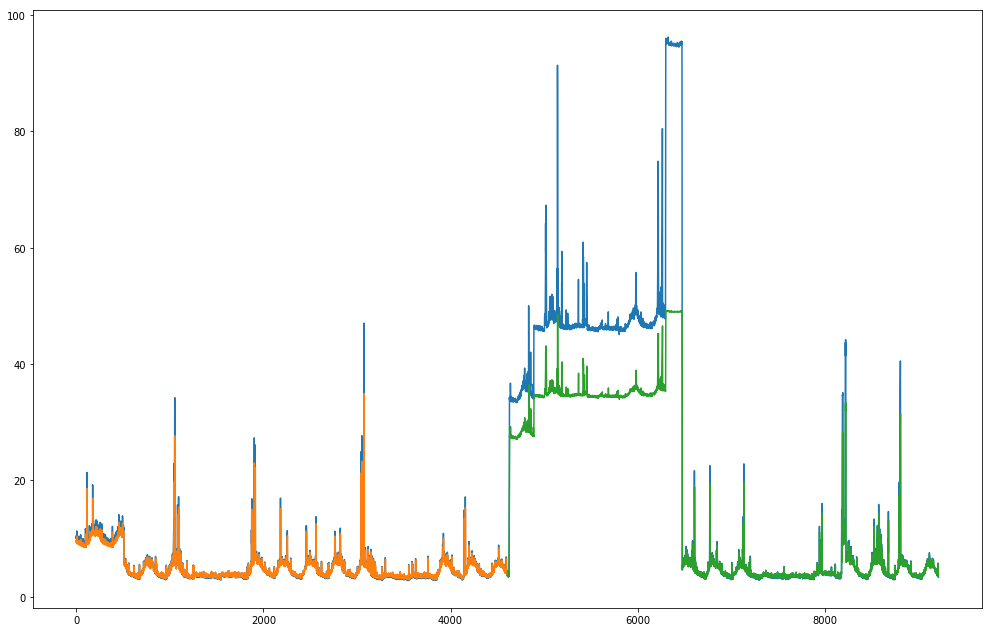

In [10]:
trainPredict = model.predict(trainX) 
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=a4_dims)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

C:\Users\n375854\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


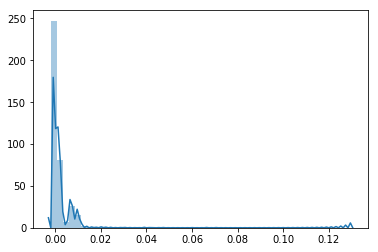

In [41]:
target = model.predict(trainX)
predictor = trainX.reshape(trainX.shape[0], 1)

e = predictor - target

import seaborn as sns
sns.distplot(e)
plt.show()

In [42]:
mu = e.mean()
sd = e.std()
sensitivity = 3.08

ub = mu + sensitivity * sd
lb = mu - sensitivity * sd 

is_anomaly = np.logical_or(e <= lb, e >= ub)

In [43]:
is_anomaly = is_anomaly.reshape(len(e),)

In [44]:
predictor2 = pd.Series(predictor.reshape(len(e)))
anomalies = predictor2[is_anomaly]

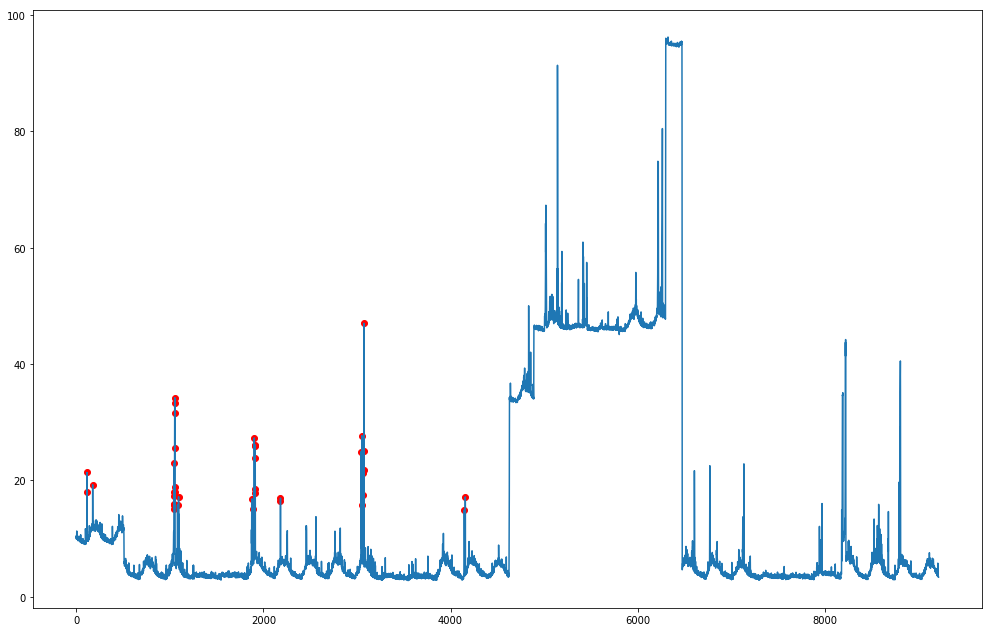

In [45]:
plt.figure(figsize=a4_dims) 
plt.plot(scaler.inverse_transform(dataset))
plt.scatter(np.array(anomalies.index), scaler.inverse_transform(np.array(anomalies).reshape(-1,1)), c='red')
plt.show()